In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm

from DynamicalSystemLayer import *
from VaeNeuralODELayer import *

# Data generation

In [2]:
p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)

In [104]:
obs.shape

torch.Size([200, 2])

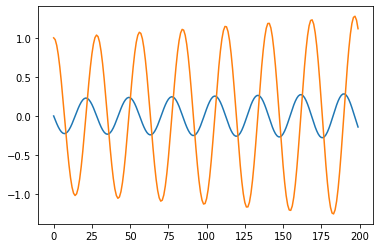

In [106]:
plt.plot(obs[:,0].detach().numpy())
plt.plot(obs[:,1].detach().numpy())
plt.show()

In [96]:
pend_data = obs
window_len = 5
window_set = pend_data.view(40, 5, 2)
times_set = times.view(40, 5)

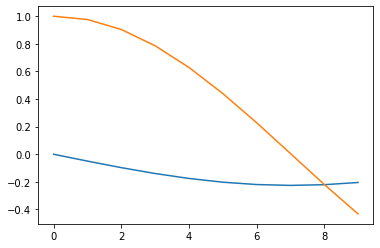

In [62]:
pend_data = obs
window_len = 5
window_set2 = pend_data.view(20, 10, 2)
times_set2 = times.view(20, 10)

plt.plot(window_set2[0,:,0].detach().numpy())
plt.plot(window_set2[0,:,1].detach().numpy())
plt.show()

In [95]:
x = torch.randn(200,2)
y = x.view(40, 5, 2)
y[0,0]

tensor([ 0.2651, -1.1379])

In [97]:
window_set.shape

torch.Size([40, 5, 2])

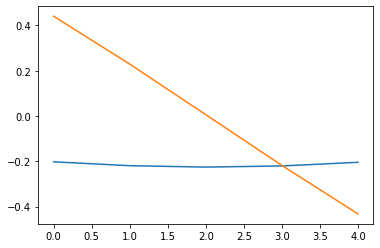

In [100]:
plt.plot(window_set[1,:,0].detach().numpy())
plt.plot(window_set[1,:,1].detach().numpy())
plt.show()

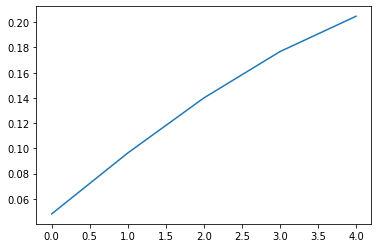

In [6]:
plt.plot(window_set[3,:,0].detach().numpy())
#plt.plot(window_set[1,:,1].detach().numpy())
plt.show()

# Model

In [ ]:
def Dynamical_System_Layer(nn.Module):
    def forward_grad(self, z, t, grad_out):
        out = self.forward(z, t)
        
        a = grad_out
        adfdp = torch.autograd.grad(out, tuple(self.parameters()), grad_outputs=a, allow_unused=True, retain_graph=True)
        
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
            
        return adfdp
    
    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)
    
    
class Dynamical_System_Function(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        z_dim = z0.size(0)
        time_len = t.size(0)
        
        z = torch.zeros(time_len, z_dim)
        z[0] = z0
        
        for it in range(time_len - 1):
            z0 = ode_solve(z0, t[it], t[it+1], func)
            z[it+1] = z0
            
        ctx.save_for_backward(flat_parameters, z.clone(), t)
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        flat_parameters, z, t = ctx.saved_tensors
        time_len = t.size(0)
        z_dim = z.size(1)
        a = grad_out.clone()
        n_param = a.shape[1]
        
        grad_weight = torch.zeros(z_dim, n_param)
        
        for it in range(time_len - 1, 1, -1):
            zi = z[it-1].view(1, z_dim)
            ti = t[it]
            ai = a[it].view(1, n_param)
            dzdpi = func.forward_grad(zi, ti, ai)
            
            grad_weight += dzdpi
        return grad_weight
        

In [119]:
class LinearODEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x0, t, A):
        time_len = t.size(0)
        x_dim = x0.size(0)
        z = torch.zeros(time_len, 2)
        z0 = x0
        with torch.no_grad():
            for it in range(time_len-1):
                #h = t[it+1] - t[it]
                z0 = z0 + A.matmul(z0)
                z[it+1] = z0

        ctx.save_for_backward(A.clone(), z.clone(), t)  
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        A, z, t = ctx.saved_tensors
        time_len = t.size(0)
        z_dim = z.size(1)
        grad_in = grad_out.clone()
        n_param = grad_in.shape[1]
        
        #adzdA = torch.zeros(time_len, n_param)
        u = torch.zeros(z_dim, n_param)
        for it in range(time_len-1, 1 ,-1):
            zi = z[it-1].view(1, z_dim)
            #ti = t[it]
            ai = grad_in[it].view(grad_in.shape[1],1)
            #h = ti - t[it-1]
            u += ai.matmul(zi)
            #adzdA[it] = u
        print(u)
        return u, None, None
         

In [213]:
#for later
class LinearODELayer(nn.Module):
    def __init__(self, data_dim):
        super(LinearODELayer, self).__init__()
        self.data_dim = data_dim
        self.A = nn.Parameter(torch.Tensor(self.data_dim, self.data_dim))
        
    def forward(self, z0, t):
        #z0 = torch.Tensor([x[0], x[1]])
        z = LinearODEFunction.apply(z0, t, self.A)
        return z

In [88]:
a = torch.randn(2,1)
z = torch.randn(1,2)

In [89]:
a.matmul(z)

tensor([[-0.6406, -0.7222],
        [-1.3856, -1.5620]])

# Training

In [6]:
dtype = torch.float
device = torch.device("cpu")

p = torch.Tensor([[0., 1., -0.05, 0]])
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))

ode_true = VaeNeuralODE(LinearODEF(p))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)
obs = obs.detach().requires_grad_(True)

pend_data = obs
window_len = 5
window_set = pend_data.view(40, 5, 2)
times_set = times.view(40, 5)



test_set = window_set[30:, :, :]
train_set = window_set[:30,:,:]

test_time = times_set[30:]
train_time = times_set[:30]

train_sample = train_set.shape[1]
test_sample = test_set.shape[1]

A = torch.randn(2,2, device=device, dtype=dtype, requires_grad=True)

In [225]:
#Crash Test with window 3
class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, z, w, b=None):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(z, w.clone(), b)
        zpred = w.matmul(z)
        if b is not None:
            zpred += b
        output = zpred.clamp(min=0)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        z, alpha, b = ctx.saved_tensors
        grad_alpha = grad_input = grad_b = None
        a = grad_output.clone()
        a[z<0]=0
        a = a.view(len(a),1)
        grad_input = a.t().matmul(z)
        
        z = z.view(1, len(z))
        grad_alpha = a.matmul(z)
        if b is not None:
            grad_b = a.squeeze(1)
        return grad_input, grad_alpha, grad_b




In [243]:
class ScalarReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z, alpha):
        ctx.save_for_backward(z, alpha.clone)
        zpred = alpha*z
        return zpred
    
    @staticmethod
    def backward(ctx, grad_out):
        z, alpha = ctx.saved_tensors
        a = grad_output.clone()
        a[z<0]=0
        a = a.view(len(a),1)
        grad_input = a.t().matmul(z)
        
        grad_alpha = a.matmul(z)
        return grad_inpu, grad_alpha
    
    
y = torch.randn(50)

print('initial alpha:')
alpha = torch.randn(1, requires_grad=True)
print(alpha)

myrelu = ScalarReLU.apply
lr = 0.01
for epoch in range(100):
    z = myrelu(y, alpha)
    loss = (z - y).pow(2).sum()
    loss.backward()
    
    with torch.no_grad():
        alpha -= lr*alpha.grad
        #b -= lr*b.grad
        
        alpha.grad.zero_()
        #b.grad.zero_()
        
print('alpha:')
print(alpha)


initial alpha:
tensor([-0.2185], requires_grad=True)


TypeError: save_for_backward can only save variables, but argument 1 is of type builtin_function_or_method

In [235]:
#without bias
x = torch.randn(2)
A = torch.Tensor([[0.,1.], [-0.5, 0.]])
print('initial A:')
print(A)
y = A.matmul(x)
alpha = torch.Tensor([[0.,1.], [-0.8, 0.]]).requires_grad_(True)
print('initial alpha:')
print(alpha)
#b = torch.randn(2).requires_grad_(True)
#print('initial b:')
#print(b)
myrelu = MyReLU.apply
lr = 0.01

for epoch in range(1000):
    z = myrelu(y, alpha)
    loss = (z - y).pow(2).sum()
    loss.backward()
    
    with torch.no_grad():
        alpha -= lr*alpha.grad
        #b -= lr*b.grad
        
        alpha.grad.zero_()
        #b.grad.zero_()
        
print('alpha:')
print(alpha)
#print('bias:', b)

initial A:
tensor([[ 0.0000,  1.0000],
        [-0.5000,  0.0000]])
initial alpha:
tensor([[ 0.0000,  1.0000],
        [-0.8000,  0.0000]], requires_grad=True)
alpha:
tensor([[ 0.0000,  1.0000],
        [-0.3810, -0.1400]], requires_grad=True)


In [236]:
#with bias
x = torch.randn(2)
y = A.matmul(y)
print('true A:')
print(A)
print('true b:')
print(torch.Tensor([[0.,0.]]))
alpha = torch.randn(2, 2).requires_grad_(True)
print('initial alpha:')
print(alpha)
b = torch.randn(2).requires_grad_(True)
print('initial b:')
print(b)
myrelu = MyReLU.apply
lr = 0.01

for epoch in range(1000):
    z = myrelu(y, alpha, b)
    loss = (z - y).pow(2).sum()
    loss.backward()
    
    with torch.no_grad():
        alpha -= lr*alpha.grad
        b -= lr*b.grad
        
        alpha.grad.zero_()
        b.grad.zero_()
        
print('alpha:')
print(alpha)
print('bias:')
print(b)

true A:
tensor([[ 0.0000,  1.0000],
        [-0.5000,  0.0000]])
true b:
tensor([[0., 0.]])
initial alpha:
tensor([[-0.7055, -0.9593],
        [-1.7464, -1.5290]], requires_grad=True)
initial b:
tensor([-0.5007,  0.6394], requires_grad=True)
alpha:
tensor([[-0.3506, -0.4283],
        [-1.4840, -1.1363]], requires_grad=True)
bias:
tensor([0.6269, 1.4732], requires_grad=True)


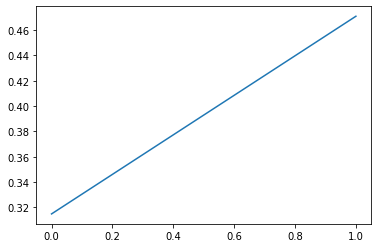

In [237]:
plt.plot(y.numpy())

In [238]:
#Crash test
class LinearFunction(Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, x, weight, bias=None):
        ctx.save_for_backward(x, weight.clone(), bias)
        output = weight.matmul(x)
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        x, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.
        grad_output = grad_output.view(1, len(grad_output))
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(torch.eye(len(x)) + weight)
        if ctx.needs_input_grad[1]:
            x = x.view(1, len(x))
            grad_weight = grad_output.t().mm(x)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias
    
    
y = window_set[3,:]
T = 5
y_pred = torch.zeros(5,2)
A = p.reshape(2,2)
print(A)

w1 = torch.Tensor([[0., 1.], [-1., 0.]]).requires_grad_(True)
#w2 = torch.randn(2,2, requires_grad=True)

lin = LinearFunction.apply
learning_rate = 0.1
for epoch in range(200):
    for n in range(train_sample):
        ytrain = train_set[n,:,:]
        z0 = torch.Tensor([ytrain[0,0], ytrain[0, 1]])
        t = train_time[n,:]
        for t in range(T-1):
            xt = y[t]
            pred = lin(xt, w1)
            y_pred[t+1] = pred.t()

            #loss = (ztrain - ytrain).pow(2).sum()
        loss = (y_pred - y).pow(2).sum()
            #train_loss += loss.item()
        loss.backward(retain_graph=True)
            
        with torch.no_grad():
            w1 -= learning_rate * w1.grad
            w1.grad.zero_()
print(w1)

tensor([[ 0.0000,  1.0000],
        [-0.0500,  0.0000]])
tensor([[ 0.9466, -0.0534],
        [ 0.9183,  0.9670]], requires_grad=True)


In [239]:
z0 = torch.Tensor([0., 1.])
A = torch.Tensor([[0.,1.],[-0.5, 0.]])
W = torch.randn(2,2, requires_grad=True)

print('Ground Truth:')
print(A)
print('Initial weight:')
print(W)
lin = LinearFunction.apply
learning_rate = 0.05
y = lin(z0, A)
for epoch in range(1000):
    z = lin(z0, W)
    loss = (z - y).pow(2).sum()
    loss.backward(retain_graph=True)
    with torch.no_grad():
        W -= learning_rate*W.grad
        W.grad.zero_()

print('Final weight:')
print(W)

Ground Truth:
tensor([[ 0.0000,  1.0000],
        [-0.5000,  0.0000]])
Initial weight:
tensor([[-0.0047, -0.9025],
        [-0.0044, -0.0440]], requires_grad=True)
Final weight:
tensor([[-4.6894e-03,  1.0000e+00],
        [-4.3520e-03, -5.6052e-45]], requires_grad=True)


In [241]:
class LinearODEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, A):
        time_len = t.size(0)
        x_dim = z0.size(0)
        z = torch.zeros(time_len, x_dim)
        z[0] = z0
        with torch.no_grad():
            for it in range(time_len-1):
                #h = t[it+1] - t[it]
                z0 = z0 + A.matmul(z0)
                z[it+1] = z0

        ctx.save_for_backward(A.clone(), z.clone(), t)  
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        A, z, t = ctx.saved_tensors
        time_len = t.size(0)
        z_dim = z.size(1)
        grad_in = grad_out.clone()
        grad_dim = grad_in.shape[1]
        
        #adzdA = torch.zeros(time_len, n_param)
        grad_z = torch.zeros(time_len, z_dim).to(grad_in)
        grad_A = torch.zeros(z_dim, z_dim).to(grad_in)
        #grad_t = torch.zeros(time_len, 1)
        
        az = torch.zeros(1, z_dim)
        #at = torch.zeros(1,1)
        for it in range(time_len-1, 1 ,-1):
            #print('step', it)
            zi = z[it-1].view(1, z_dim)
            zi = zi.detach().requires_grad_(True)
            ai = grad_in[it].view(grad_in.shape[1],1)
            az = ai.t() - az.matmul(torch.eye(z_dim) + A)
            grad_A += ai.matmul(zi)
            grad_z[it] = az#.view(z_dim)
        return grad_A, grad_z, None



In [5]:
y = window_set[3,:]
t = times_set[3,:]
A = p.reshape(2,2)
print(A)

w1 = torch.Tensor([[0., 1.], [-1., 0.]]).requires_grad_(True)

ode = LinearODEFunction.apply
learning_rate = 0.01

for epoch in range(100):
    z = ode(y[0], t, w1)
    loss = (z - y).pow(2).sum()
    loss.backward(retain_graph=True)
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w1.grad.zero_()

print(w1)

tensor([[ 0.0000,  1.0000],
        [-0.0500,  0.0000]])
tensor([[ 0.,  1.],
        [-1.,  0.]], requires_grad=True)


# Functional machine learning

In [57]:
class DynamicalFunctional(nn.Module):
    def forward_grad(self, z, t, grad_out):
        out = self.forward(z, t)
        a = grad_out
        adfdz, adfdt, *adfdw = torch.autograd.grad((out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True)
        
        if adfdw is not None:
            adfdw= torch.cat([w_grad.flatten() for w_grad in adfdw]).unsqueeze(0)
            afdw = grad_weight.expand(1, -1) 
        if adfdt is not None:
            adfdt = adfdt.expand(1, 1)
            
        return adfdz, adfdt, adfdw

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)


class DynamicalSystemFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, weight, func):
        z_dim = z0.size(1)
        time_len = t.size(0)
        z = torch.zeros(time_len, z_dim)
        z[0] = z0
        with torch.no_grad():
            for it in range(time_len-1):
                #h = t[it+1] - t[it]
                z0 = z0 + func(z0, t)
                z[it+1] = z0
        ctx.func = func
        ctx.save_for_backward(z.clone(), t, weight)
        return z
    
    @staticmethod
    def backward(ctx, grad_out):
        func = ctx.func
        z, t, w = ctx.saved_tensors
        time_len = t.size(0)
        z_dim = z.size(1)
        
        grad_in = grad_out.clone()
        grad_dim = grad_in.shape[1]
        
        grad_z = torch.zeros(time_len, z_dim, 1).to(grad_in)
        grad_t = torch.zeros(time_len, 1, 1).to(grad_in)
        grad_w = torch.zeros(z_dim, z_dim).to(grad_in)
        
        adfdz = torch.zeros(z_dim,1)
        adfdt = torch.zeros(1)
        for it in range(time_len-1, 0, -1):
            zi = z[it].view(1, z_dim)
            ti = t[it]
            ti = ti.detach().requires_grad_(True)
            zi = zi.detach().requires_grad_(True) 
            ai = grad_in[it].view(grad_in.shape[1],1)
            
            
            grad_z[it] = ai + adfdz
            
            adfdz, adfdt, adfdw = func.forward_grad(zi, ti, ai)
            
            grad_w += adfdw
            
            
            grad_t[it] += adfdt
            
        return grad_z, grad_t, grad_w
    
    
class DynamicalSystemLayer(nn.Module):
    def __init__(self, func):
        super(DynamicalSystemLayer, self).__init__()
        self.func = func
        
    def forward(self, z0, t, return_whole_sequence=True):
        t = t.to(z0)
        z = DynamicalSystemFunction.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]
        

class LinearODE(DynamicalFunctional):
    def __init__(self, w):
        super(LinearODE, self).__init__()
        self.lin = nn.Linear(w.size(1), w.size(1), bias=False)
        self.lin.weight = nn.Parameter(w)
        
    def forward(self, z, t):
        out = self.lin(z)
        return out

In [58]:
z0 = torch.Tensor([[0., 1.]])

times = torch.from_numpy(np.arange(0,200))
A = torch.Tensor([[0.,1.], [-0.5, 0.]])
W = torch.randn(2,2).detach().requires_grad_(True)

ode_true = DynamicalSystemLayer(LinearODE(A))
print('Ground truth:')
print(tuple(ode_true.parameters()))
obs = ode_true(z0, times, return_whole_sequence=True).detach()
obs = obs.squeeze(1)
obs = obs.detach().requires_grad_(True)

pend_data = obs
window_len = 5
window_set = pend_data.view(40, 5, 2)
times_set = times.view(40, 5)

y = window_set[3,:]

ode_train = DynamicalSystemLayer(LinearODE(W))
print('Initial weight:')
print(tuple(ode_train.parameters()))

learning_rate = 0.01

for epoch in range(100):
    z0 = torch.Tensor([[y[0][0], y[0][1]]])
    z = ode_train(z0, t, return_whole_sequence=True)
    loss = (z - y).pow(2).sum()
    loss.backward(retain_graph=True)
    with torch.no_grad():
        for p in ode_train.parameters():
            p -= learning_rate*p.grad

print('Final weignt')
print(tuple(ode_train.parameters()))

Ground truth:
(Parameter containing:
tensor([[ 0.0000,  1.0000],
        [-0.5000,  0.0000]], requires_grad=True),)
Initial weight:
(Parameter containing:
tensor([[ 1.4721,  0.0550],
        [-1.4497,  0.2398]], requires_grad=True),)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [33]:
y[0]

tensor([  5.6641, -20.5391], grad_fn=<SelectBackward>)

In [38]:
z0.size(0)

1

In [35]:
torch.Tensor([[y[0][0], y[0][1]]])

tensor([[  5.6641, -20.5391]])

In [28]:
tuple(ode_true.parameters())

(Parameter containing:
 tensor([[ 0.0000,  1.0000],
         [-0.5000,  0.0000]], requires_grad=True),)

In [177]:
A

tensor([[ 0.0321, -0.0059],
        [ 0.0682,  0.0345]], requires_grad=True)

In [122]:
print('start training')
for epoch in range(5):
    ode = LinearODEFunction.apply
    
    for n in range(train_sample):
        ytrain = train_set[n,:,:]
        z0 = torch.Tensor([ytrain[0,0], ytrain[0, 1]])
        t = train_time[n,:]
        ztrain = ode(z0, t, A)
        
        #loss = (ztrain - ytrain).pow(2).sum()
        loss = loss_fn(ztrain, ytrain)
        #train_loss += loss.item()
        loss.backward()
        print(A.grad)

start training
tensor([[ 98.8130, -13.8295],
        [-11.3519,   1.5852]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[59.2239, -8.2826],
        [-9.3418,  1.3064]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[10.8214, -1.5171],
        [-0.2947,  0.0391]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[114.2538, -15.9884],
        [-13.9609,   1.9504]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[36.9698, -5.1689],
        [-6.4560,  0.9028]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[ 98.8130, -13.8295],
        [-11.3519,   1.5852]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[59.2239, -8.2826],
        [-9.3418,  1.3064]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[10.8214, -1.5171],
        [-0.2947,  0.0391]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[114.2538, -15.9884],
        [-13.9609,   1.9504]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[36.9698, -5.1689],
        [-6.4560,  0.9028]])
tensor([[0., 0.],
        [0., 0.]])
tensor([[ 98.8130, -13.8295],

In [89]:
A

tensor([[2.0170, 0.7242],
        [0.1959, 0.4952]], requires_grad=True)